In [1]:
import pandas as pd
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("weatherAUS.csv") 

In [6]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [8]:
df.dtypes

Date             datetime64[ns]
Location                 object
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
Evaporation             float64
Sunshine                float64
WindGustDir              object
WindGustSpeed           float64
WindDir9am               object
WindDir3pm               object
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Cloud9am                float64
Cloud3pm                float64
Temp9am                 float64
Temp3pm                 float64
RainToday                object
RainTomorrow             object
dtype: object

In [9]:
selected_features = ['Rainfall', 'MaxTemp', 'MinTemp','Sunshine','Evaporation']
data = df[selected_features].values

In [10]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [11]:
def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length:i + sequence_length + 1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [12]:
sequence_length = 10

In [13]:
X, y = create_sequences(data, sequence_length)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [15]:
print(np.isnan(X_train).any())
print(np.isnan(y_train).any())

True
True


In [16]:
X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))
y_train = np.nan_to_num(y_train, nan=np.nanmean(y_train))
X_test = np.nan_to_num(X_test, nan=np.nanmean(X_test))
y_test = np.nan_to_num(y_test, nan=np.nanmean(y_test))

In [17]:
print(np.isnan(X_train).any())
print(np.isnan(y_train).any())

False
False


In [18]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(X_train.shape[2], activation='linear')))

In [19]:
model.compile(optimizer='adam', loss='mse')


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42400     
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 100)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 10, 100)           80400     
                                                                 
 time_distributed (TimeDist  (None, 10, 5)             505       
 ributed)                                                        
                                                                 
Total params: 123305 (481.66 KB)
Trainable params: 123305 (481.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history=model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
728/728 [==============================] - 39s 50ms/step - loss: 0.0220 - val_loss: 0.0192
Epoch 2/100
728/728 [==============================] - 40s 55ms/step - loss: 0.0191 - val_loss: 0.0187
Epoch 3/100
728/728 [==============================] - 40s 55ms/step - loss: 0.0190 - val_loss: 0.0192
Epoch 4/100
728/728 [==============================] - 43s 58ms/step - loss: 0.0190 - val_loss: 0.0186
Epoch 5/100
728/728 [==============================] - 43s 60ms/step - loss: 0.0190 - val_loss: 0.0187
Epoch 6/100
728/728 [==============================] - 44s 61ms/step - loss: 0.0189 - val_loss: 0.0188
Epoch 7/100
728/728 [==============================] - 45s 62ms/step - loss: 0.0189 - val_loss: 0.0187
Epoch 8/100
728/728 [==============================] - 57s 78ms/step - loss: 0.0189 - val_loss: 0.0188
Epoch 9/100
728/728 [==============================] - 68s 94ms/step - loss: 0.0189 - val_loss: 0.0193


In [23]:
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

910/910 [==============================] - 15s 17ms/step - loss: 0.0177
Mean Squared Error on Test Set: 0.017713351175189018


In [24]:
predictions = model.predict(X_test)


910/910 [==============================] - 16s 16ms/step


In [25]:
threshold = 0.7
binary_predictions = (predictions > threshold).astype(int)
binary_actual_values = (y_test > threshold).astype(int)
min_length = min(len(binary_predictions), len(binary_actual_values))
binary_predictions = np.array(binary_predictions[:min_length])
binary_actual_values = np.array(binary_actual_values[:min_length])


In [26]:
# Calculate accuracy
accuracy = np.mean(binary_predictions == binary_actual_values)
print(f'Accuracy on Test Set: {accuracy:.5%}')

Accuracy on Test Set: 92.10663%


In [27]:
from sklearn.metrics import precision_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

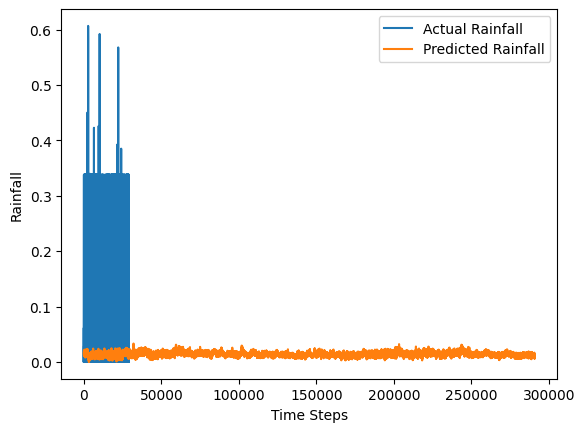

In [28]:
plt.plot(y_test[:, :, 0].flatten(), label='Actual Rainfall')
plt.plot(predictions[:, :, 0].flatten(), label='Predicted Rainfall')
plt.xlabel('Time Steps')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

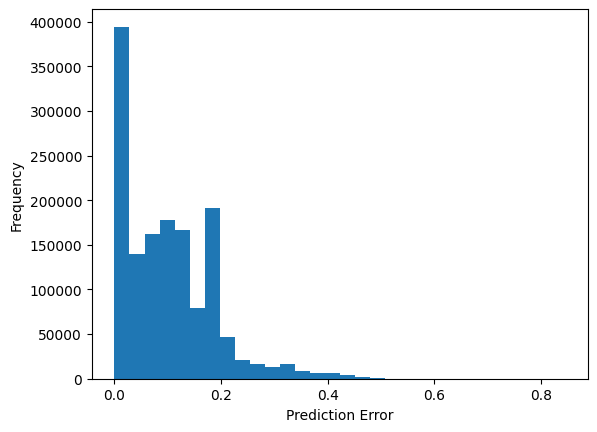

In [29]:
errors = np.abs(predictions - y_test)
plt.hist(errors.flatten(), bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


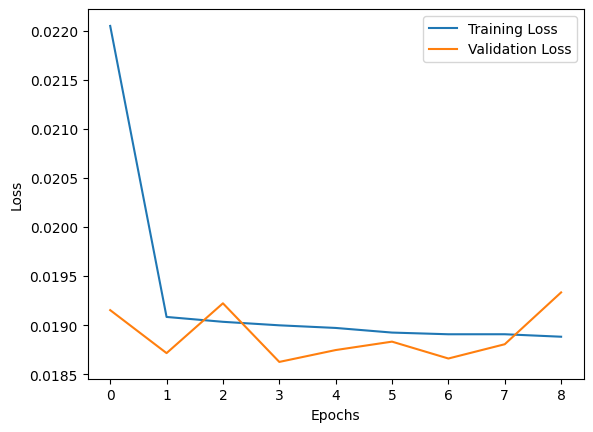

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


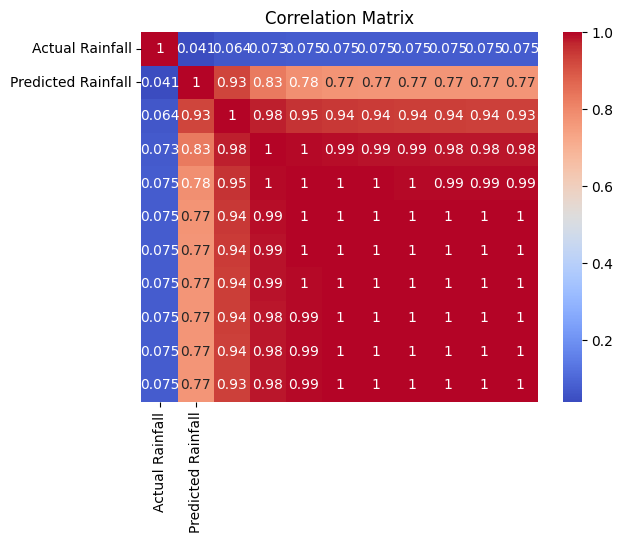

In [31]:
import seaborn as sns

correlation_matrix = np.corrcoef(y_test[:, :, 0], predictions[:, :, 0], rowvar=False)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=['Actual Rainfall', 'Predicted Rainfall'], yticklabels=['Actual Rainfall', 'Predicted Rainfall'])
plt.title('Correlation Matrix')
plt.show()


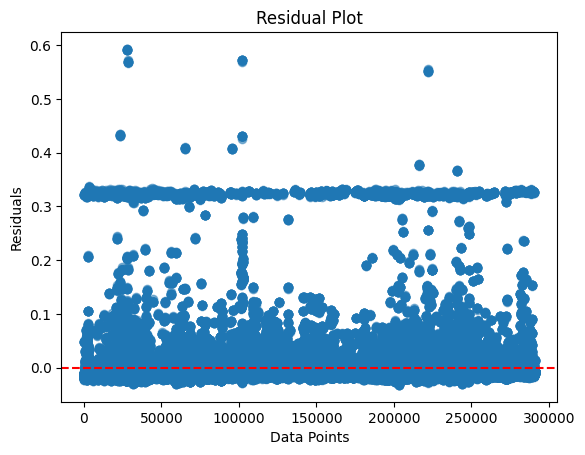

In [32]:
residuals = y_test[:, :, 0] - predictions[:, :, 0]
plt.scatter(range(len(residuals.flatten())), residuals.flatten(), alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Data Points')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


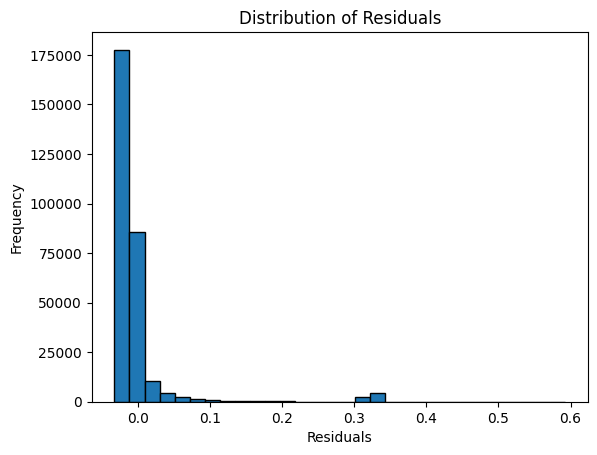

In [33]:
plt.hist(residuals.flatten(), bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()


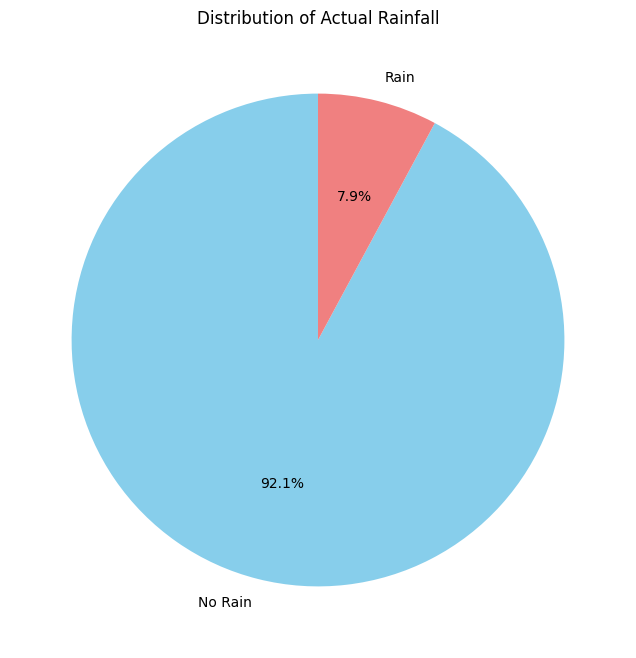

In [34]:
plt.figure(figsize=(8, 8))
labels = ['No Rain', 'Rain']
sizes = [np.sum(binary_actual_values == 0), np.sum(binary_actual_values == 1)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Actual Rainfall')
plt.show()


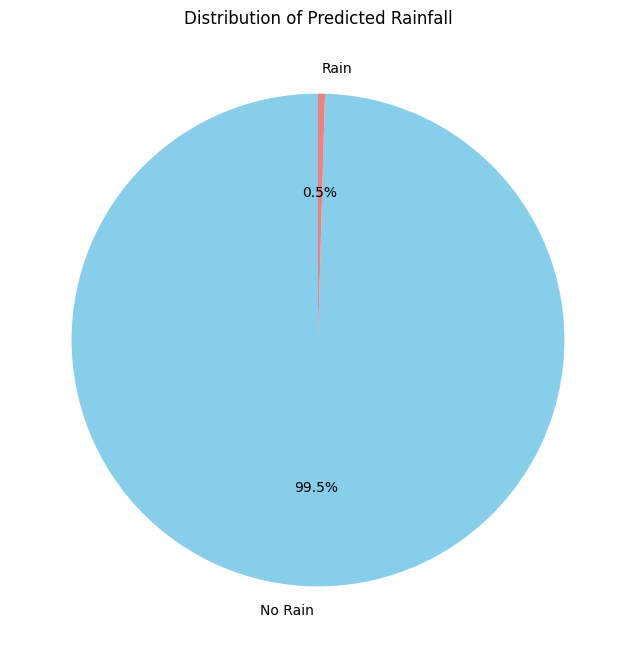

In [35]:
plt.figure(figsize=(8, 8))
labels = ['No Rain', 'Rain']
sizes = [np.sum(binary_predictions == 0), np.sum(binary_predictions == 1)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Predicted Rainfall')
plt.show()


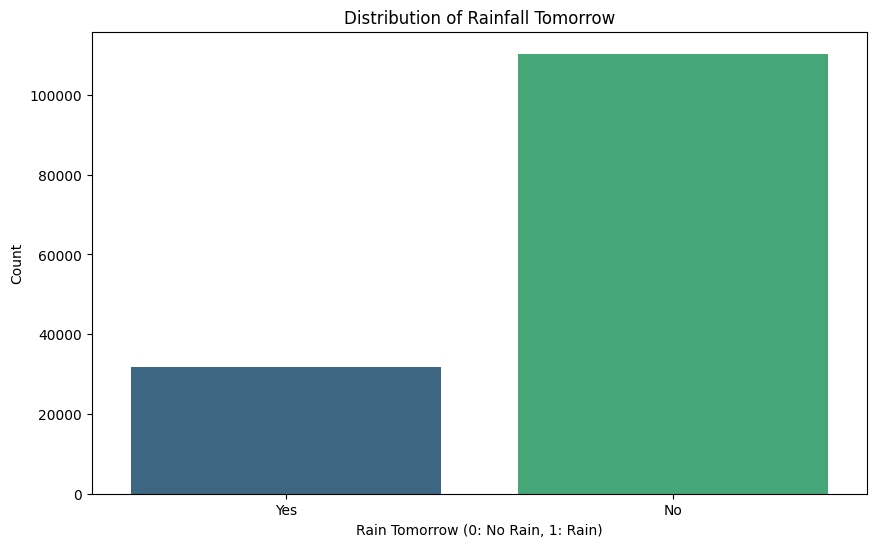

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(x='RainTomorrow', data=df, palette='viridis')
plt.title('Distribution of Rainfall Tomorrow')
plt.xlabel('Rain Tomorrow (0: No Rain, 1: Rain)')
plt.ylabel('Count')
plt.show()


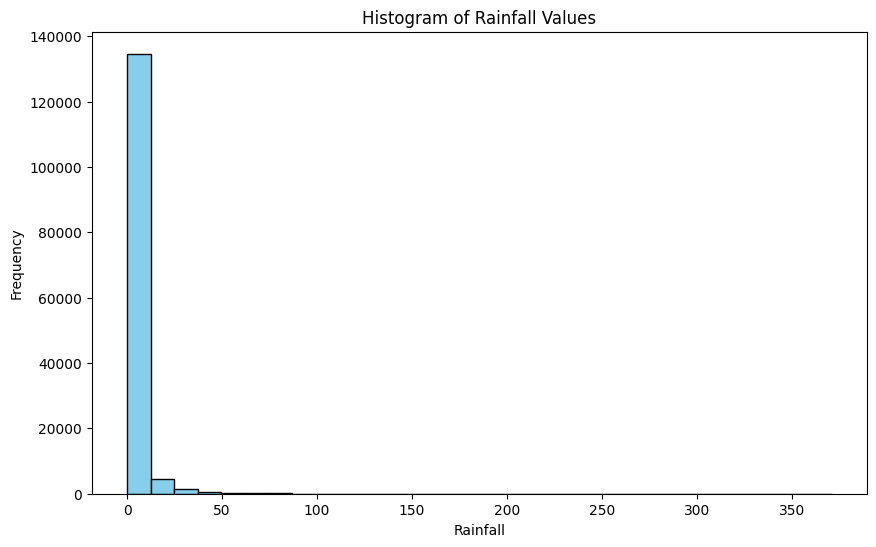

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(df['Rainfall'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Rainfall Values')
plt.xlabel('Rainfall')
plt.ylabel('Frequency')
plt.show()


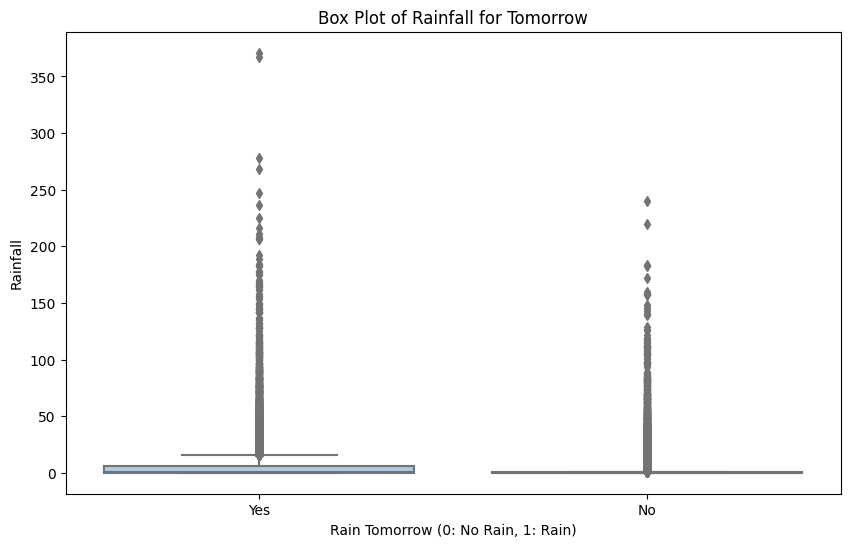

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='RainTomorrow', y='Rainfall', data=df, palette='pastel')
plt.title('Box Plot of Rainfall for Tomorrow')
plt.xlabel('Rain Tomorrow (0: No Rain, 1: Rain)')
plt.ylabel('Rainfall')
plt.show()


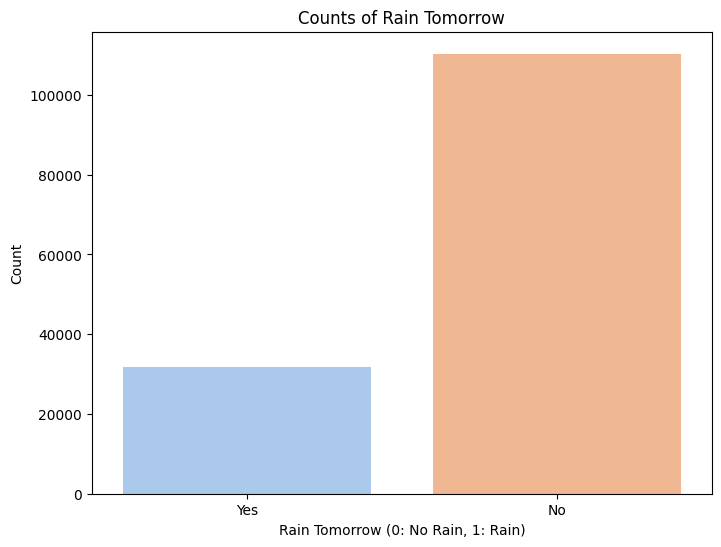

In [39]:
plt.figure(figsize=(8, 6))
sns.countplot(x='RainTomorrow', data=df, palette='pastel')
plt.title('Counts of Rain Tomorrow')
plt.xlabel('Rain Tomorrow (0: No Rain, 1: Rain)')
plt.ylabel('Count')
plt.show()


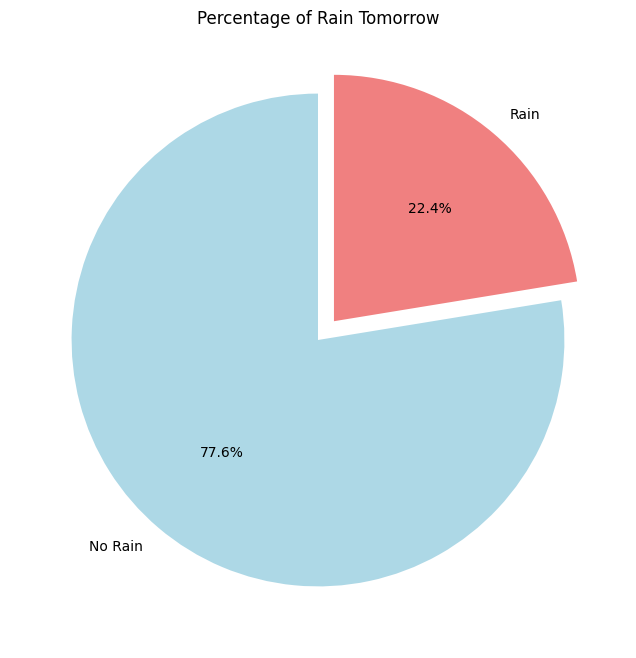

In [40]:
plt.figure(figsize=(8, 8))
labels = ['No Rain', 'Rain']
sizes = df['RainTomorrow'].value_counts(normalize=True) * 100
colors = ['lightblue', 'lightcoral']
explode = (0, 0.1)  # Explode the 'Rain' slice
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Percentage of Rain Tomorrow')
plt.show()


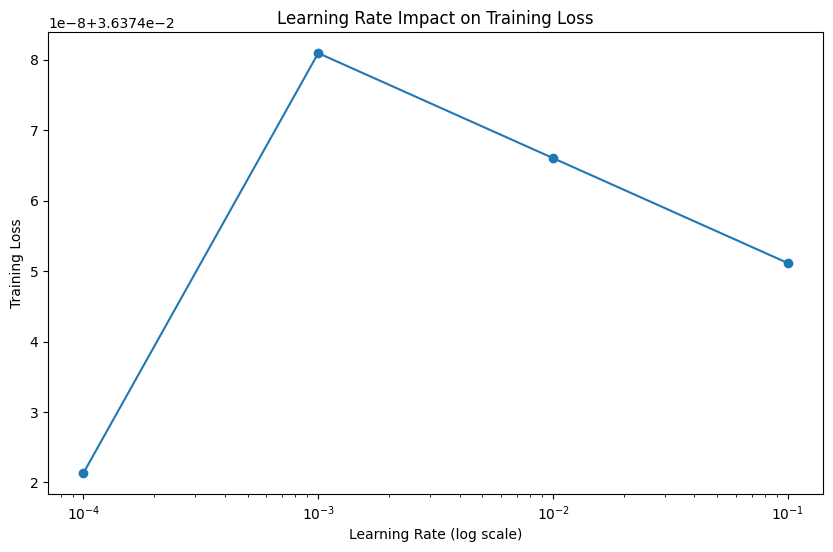

In [46]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Define a range of learning rates to experiment with
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]

# Lists to store training losses for each learning rate
train_losses = []

# Define your model (assuming 'model' is your LSTM model)
model = Sequential()
# ... (your model definition)

# Compile the model with an optimizer (e.g., Adam)
for lr in learning_rates:
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')
    
    # Train the model and store the training loss
    history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    train_losses.append(history.history['loss'][-1])

# Plot the learning rate impact
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_losses, marker='o')
plt.xscale('log')  # Use a logarithmic scale for better visibility
plt.title('Learning Rate Impact on Training Loss')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Training Loss')
plt.show()

In [47]:
import numpy as np
from sklearn.metrics import matthews_corrcoef, precision_score

# Trim arrays to have the same length
min_length = min(len(binary_actual_values), len(binary_predictions))
binary_actual_values = binary_actual_values[:min_length]
binary_predictions = binary_predictions[:min_length]

# Calculate MCC
mcc = matthews_corrcoef(binary_actual_values, binary_predictions)
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# Calculate Precision
precision = precision_score(binary_actual_values, binary_predictions)
print(f'Precision: {precision:.4f}')

Matthews Correlation Coefficient: 0.0417
Precision: 0.2440
